In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch as th

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm

import glob
import re

import time

C:\Users\uljah\anaconda3\envs\NeuralNetw38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CombineDataset_1(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, is_valid):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.is_valid = is_valid
        
        if self.is_valid == 1:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
        else:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
            
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.frame[self.id_col].iloc[idx]
        img = os.path.join (self.path_imgs, img_name +'.jpg')

        image1 = Image.open(img)
        image = self.aug(image1)

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return image, feats, label, name
    
class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, use_cache = False, transform = None):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.inputs_dtype = torch.float32
        
        self.transform = transform
        
        self.use_cache = use_cache
        
        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.path_imgs)), desc='Caching')
            
            for i, img in zip(progressbar, self.path_imgs):
                img = Image.open(img)
                if self.transform is not None:
                    img= self.transform(img)
                
                self.cached_data.append(img)
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.cached_data[idx]

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return img, feats, label, name
    

def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, y):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Error')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [4]:
data_dir = "C:\\Users\\...\\DATASET\\"
metadata = pd.read_csv('C:\\Users\\...\\MetaData.csv')

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:\\Users\\...\\DATASET\\*.jpg'), key=numericalSort)

labels_cat = ['0. vascular lesions', '1. nevus', '2. solar lentigo', '3. dermatofibroma', '4. seborrheic ketarosis', '5. benign ketarosis', '6. actinic keratosis', '7. basal cell carcinoma', '8. squamous cell carcinoma', '9. melanoma']

    #CPU или GPU
device = get_default_device()

In [5]:
metadata_age = metadata[['age']]
Age_grup = []

for i in metadata_age['age']:
    if i <= 44:
        Age_grup += ['young']
    elif 45 <= i <= 59:
        Age_grup += ['middle']
    elif 60 <= i <= 74:
        Age_grup += ['elderly']
    elif 75 <= i:
        Age_grup += ['senile']
    else:
        Age_grup += ['error']
        
metadata['age'] = Age_grup

In [ ]:
encode_map_categor = {'0. vascular lesions': 0, '1. nevus': 1, '2. solar lentigo': 2, '3. dermatofibroma': 3, '4. seborrheic keratosis': 4, '5. benign ketarosis': 5, '6. actinic keratosis': 6, '7. basal cell carcinoma': 7, '8. squamous cell carcinoma': 8, '9. melanoma': 9}

encode_map_age = {'young': 0, 'middle': 1, 'elderly': 2, 'senile': 3}
encode_map_sex = {'male': 0, 'female': 1}
encode_map_anatomloc = {'anterior torso': 0, 'head/neck': 1, 'lateral torso': 2, 'lower extremity': 3, 'oral/genital': 4, 'palms/soles': 5, 'posterior torso': 6, 'upper extremity': 7}

metadata['diagnosis'].replace(encode_map_categor, inplace=True)
metadata['age'].replace(encode_map_age, inplace=True)
metadata['sex'].replace(encode_map_sex, inplace=True)
metadata['anatomloc'].replace(encode_map_anatomloc, inplace=True)

In [ ]:
label_images = []
le = OneHotEncoder()

label_encoded1 = le.fit_transform(metadata['diagnosis'].astype(str))
metadata['diagnosis'] = label_encoded1

label_encoded2 = le.fit_transform(metadata['age'].astype(str))
metadata['age'] = label_encoded2

label_encoded3 = le.fit_transform(metadata['sex'].astype(str))
metadata['sex'] = label_encoded3

label_encoded4 = le.fit_transform(metadata['anatomloc'].astype(str))
metadata['anatomloc'] = label_encoded4

In [ ]:
test_size = 0.2
val_size = 0.25

data_label = metadata['diagnosis'].to_numpy()

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()

indices = {'train': pre_train_indices[train_indices],
           'val': pre_train_indices[val_indices],
           'test': test_indices}

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']

In [7]:
def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        m = metadata['diagnosis'].value_counts()
        counts[i] = m[i]
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

weight = estimate_weights_mfb(labels_cat)
weight = torch.FloatTensor(weight).to(device)

for i in range(len(labels_cat)):
    print(labels_cat[i],":", weight[i])

In [8]:
test_set = CombineDataset(metadata,'name','diagnosis',data_dir2, is_valid = 0)
testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False,  sampler = test_indices)

Caching: 100%|██████████████████████████████████████████████████████████████████| 41725/41725 [03:36<00:00, 192.40it/s]


In [10]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
resnext50_32x4d.fc = nn.Linear(2048,num_classes)

class Classification_M(nn.Module):
    def __init__(self):
        super(Classification_M, self).__init__()
        
        self.layer_1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        
        self.layer_2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(32)
        
        self.layer_out = nn.Linear(32, num_classes) 
        
        
    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        
        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        x = self.layer_out(x)
        
        return x

Classification_M = Classification_M()    
    
class MultimodalNN(nn.Module):
    def __init__(self):
        super(MultimodalNN, self).__init__()
        
        self.CNN = resnext50_32x4d
       
        self.meta_net = Classification_M
        
        self.out = nn.Linear(num_classes+num_classes, num_classes)
                
    def forward(self, img , tab):
        
        img = self.CNN(img) 
        img = img.reshape(img.shape[0], -1)
        
        tab = self.meta_net(tab)
        
        x = torch.cat((img, tab),1)
        x = self.out(x)
        
        return x

MultimodalNN = MultimodalNN()
MultimodalNN = MultimodalNN.to(device)

model_name = 'C:\\Users\\...\\resnext50_32x4d_weight.pt'

model_weights = torch.load(model_name, device)
MultimodalNN.load_state_dict(model_weights)
model = MultimodalNN.to(device)

C:\Users\uljah\anaconda3\envs\NeuralNetw38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uljah\anaconda3\envs\NeuralNetw38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
actuals = []
predictions = []
    
with torch.no_grad():
    
    for data in testloader:
        image, feats, label = data
        image, feats, label = image.to(device), feats.to(device), label.to(device)
            
        output = model(image, feats)
        
        pred = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()
        
        predictions.extend(pred)
        
        label = label.cpu().data.numpy()
        actuals.extend(label)

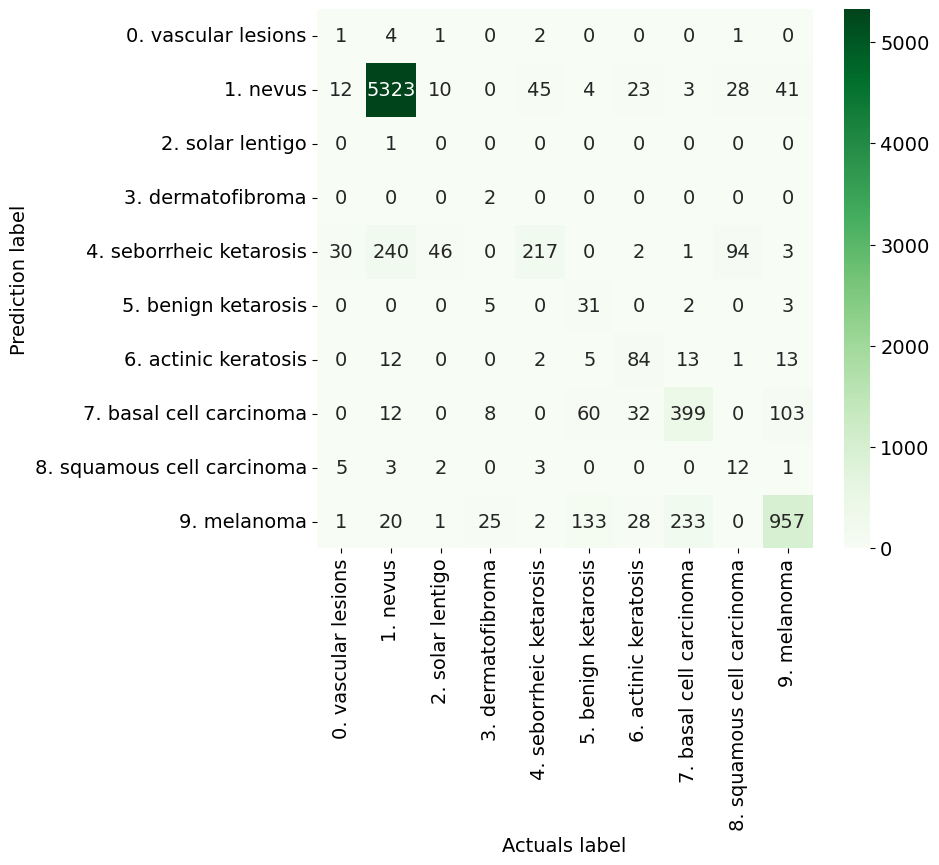

In [19]:
matrix = confusion_matrix(predictions, actuals)

df_matrix = pd.DataFrame(matrix, label2, label2)

plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [20]:
from torchmetrics.classification import MulticlassSpecificity
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

cm = confusion_matrix(actuals, predictions)
FP = np.mean(cm.sum(axis=0) - np.diag(cm))  
FN = np.mean(cm.sum(axis=1) - np.diag(cm))
TP = np.mean(np.diag(cm))
TN = np.mean(cm.sum() - (FP + FN + TP))

Sensitivity = (TP/(TP+FN))
Specificity = (TN/(TN+FP))
Precision = (TP/(TP+FP))
NPV = (TN/(TN+FN))
PPV = (TP/(TP+FP))
FNR = (FN/(FN+TP))
FPR = (FP/(FP+TN))

F1 = (2*TP)/((2*TP)+FP+FN)

print('Sensitivity: %.4f' % Sensitivity)
print('Specificity: %.4f' % Specificity)
print('Precision: %.4f' % Precision)
print('NPV: %.4f' % NPV)
print('PPV: %.4f' % PPV)
print('FNR: %.4f' % FNR)
print('FPR: %.4f' % FPR)
print('F1: %.4f' % F1)

# recall_score = tp / (tp + fn)

recall_1 = recall_score(actuals, predictions, average='micro')
print('Recall micro: %.f' % recall_1)
recall_2 = recall_score(actuals, predictions, average='macro')
print('Recall macro: %.4f' % recall_2)

# precision_score = tp / (tp + fp)

precision_1 = precision_score(actuals, predictions, average='micro')
print('Precision micro: %.4f' % precision_1)
precision_2 = precision_score(actuals, predictions, average='macro')
print('Precision macro: %.4f' % precision_2)

# F1 = 2 * (precision * recall) / (precision + recall)

f1_1 = f1_score(actuals, predictions, average='micro')
print('F1 score micro: %.4f' % f1_1)
f1_2 = f1_score(actuals, predictions, average='macro')
print('F1 score macro: %.4f' % f1_2)


jaccard_1 = jaccard_score(actuals, predictions, average='micro')
print('Jaccard score micro: %.4f' % jaccard_1)
jaccard_2 = jaccard_score(actuals, predictions, average='macro')
print('Jaccard score macro: %.4f' % jaccard_2)

accuracy_1 = accuracy_score(actuals, predictions)
print('Accuracy score: %.4f' % accuracy_1)


MCC = matthews_corrcoef(actuals, predictions)
print('Matthews corrcoef: %.4f' % MCC)

pre = torch.tensor(predictions)
ac = torch.tensor(actuals)

# Specificity = tn / tn + fp

specificity1 = MulticlassSpecificity(average='macro', num_classes=10)
s1 = specificity1(pre, ac)
print('Specificity macro: %.4f' % s1)

specificity2 = MulticlassSpecificity(average='micro', num_classes=10)
s2 = specificity2(pre, ac)
print('Specificity micro: %.4f' % s2)

specificity3 = MulticlassSpecificity(average='weighted', num_classes=10)
s3 = specificity3(pre, ac)
print('Specificity weighted: %.4f' % s3)

specificity4 = MulticlassSpecificity(average='none', num_classes=10)
s4 = specificity4(pre, ac)
print('Specificity none - class vascular lesions (0): %.4f' % s4[0])
print('Specificity none - class nevus (1): %.4f' % s4[1])
print('Specificity none - class solar lentigo (2): %.4f' % s4[2])
print('Specificity none - class dermatofibroma (3): %.4f' % s4[3])
print('Specificity none - class seborrheic ketarosis (4): %.4f' % s4[4])
print('Specificity none - class benign ketarosis (5): %.4f' % s4[5])
print('Specificity none - class actinic keratosis (6): %.4f' % s4[6])
print('Specificity none - class basal cell carcinoma (7): %.4f' % s4[7])
print('Specificity none - class squamous cell carcinoma (8): %.4f' % s4[8])
print('Specificity none - class melanoma (9): %.4f' % s4[9])

Sensitivity: 0.8419
Specificity: 0.9824
Precision: 0.8419
NPV: 0.9824
PPV: 0.8419
FNR: 0.1581
FPR: 0.0176
F1: 0.8419
Recall micro: 1
Recall macro: 0.4004
Precision micro: 0.8419
Precision macro: 0.5621
F1 score micro: 0.8419
F1 score macro: 0.3895
Jaccard score micro: 0.7270
Jaccard score macro: 0.2975
Accuracy score: 0.8419
Matthews corrcoef: 0.7023
Specificity macro: 0.9789
Specificity micro: 0.9824
Specificity weighted: 0.9468
Specificity none - class vascular lesions (0): 0.9990
Specificity none - class nevus (1): 0.9392
Specificity none - class solar lentigo (2): 0.9999
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9485
Specificity none - class benign ketarosis (5): 0.9988
Specificity none - class actinic keratosis (6): 0.9944
Specificity none - class basal cell carcinoma (7): 0.9721
Specificity none - class squamous cell carcinoma (8): 0.9983
Specificity none - class melanoma (9): 0.9387


In [21]:
def binar_matrix (matrix):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(6):
        matrixTP = matrix[i][:6]
        matrixFP = matrix[i][6:]
        for number in matrixTP:
            TP += number
        for number in matrixFP:
            FP += number
    for i in range(4):
        matrixFN = matrix[i+6][:6]
        matrixTN = matrix[i+6][6:]
        for number in matrixFN:
            FN += number
        for number in matrixTN:
            TN += number
    return TP, TN, FP, FN

TP, TN, FP, FN  = binar_matrix(matrix)

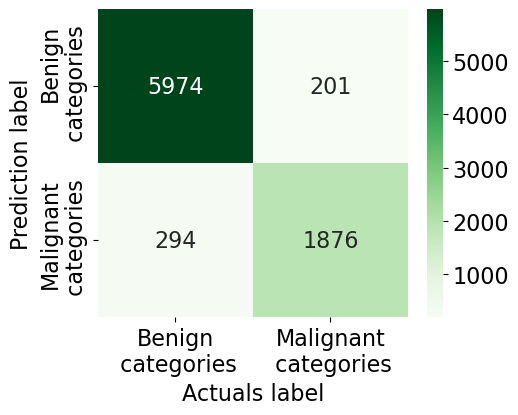

In [22]:
binar_data = [[TP, FP], [FN, TN]]
binarmatrix = torch.tensor(binar_data)

categories = ['Benign\n categories', 'Malignant\n categories']

df_matrix = pd.DataFrame(binarmatrix, categories, categories)
plt.rcParams['font.size'] = '16'

plt.figure(figsize = (5,4))
sns.heatmap(df_matrix, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

In [23]:
Sensitivity = (TP / (TP + FN))
Specificity = (TN / (TN + FP))

Precision = (TP / (TP + FP))

NPV = (TN / (TN + FN))
PPV = (TP / (TP + FP))
FNR = (FN / (FN + TP))
FPR = (FP / (FP + TN))

F1 = (2 * TP) / ((2 * TP) + FP + FN)

Acc = (TP + TN) / (TP + TN + FP + FN)

def mcc(TP, FP, TN, FN):
    x1 = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)
    x2 = ((TP * TN) - (FP * FN)) / sqrt(x1)
    return x2

MCC = mcc(TP, FP, TN, FN)

print('Onco Sensitivity: %.4f' % Sensitivity)
print('Onco Specificity: %.4f' % Specificity)
print('\nOnco Accuracy: %.4f' % Acc)
print('Onco F1: %.4f' % F1)
print('Onco Matthews corrcoef: %.4f' % MCC)
print('\nOnco FNR: %.4f' % FNR)
print('Onco FPR: %.4f' % FPR)
print('Onco NPV: %.4f' % NPV)
print('Onco PPV: %.4f' % PPV)

Onco Sensitivity: 0.9531
Onco Specificity: 0.9032

Onco Accuracy: 0.9407
Onco F1: 0.9602
Onco Matthews corrcoef: 0.8441

Onco FNR: 0.0469
Onco FPR: 0.0968
Onco NPV: 0.8645
Onco PPV: 0.9674
